In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# 设置 seaborn 背景样式
sns.set_style('whitegrid')

In [3]:
# 使得可以在 notebook 中绘图
%matplotlib inline

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.info()
print '--------------------------------'
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object


In [6]:
 # 去除无关列
train_df = train_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df = test_df.drop(['Name','Ticket'], axis=1)

In [7]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [8]:
from scipy.stats import mode
mode(train_df['Embarked'].dropna()).mode[0]

D:\Python\Anaconda\Anaconda2.7\lib\site-packages\scipy\stats\stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


'S'

### 逐个进行分析特征，找到有用特征

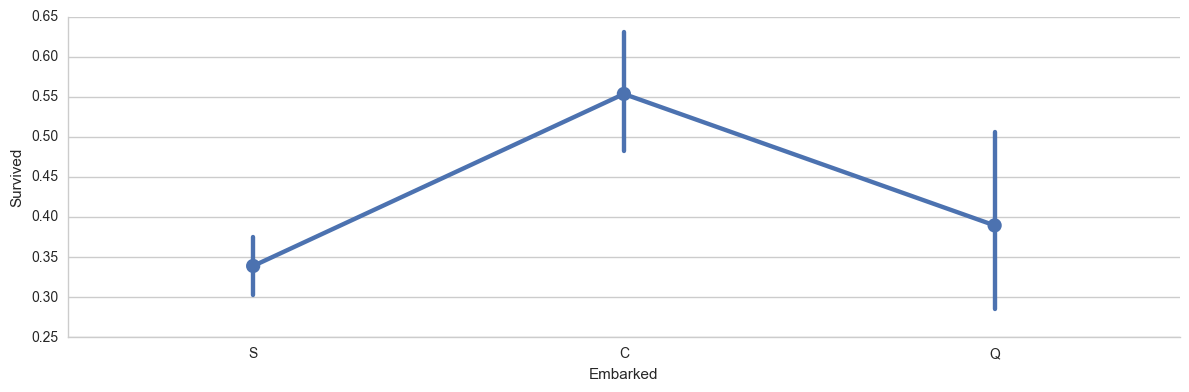

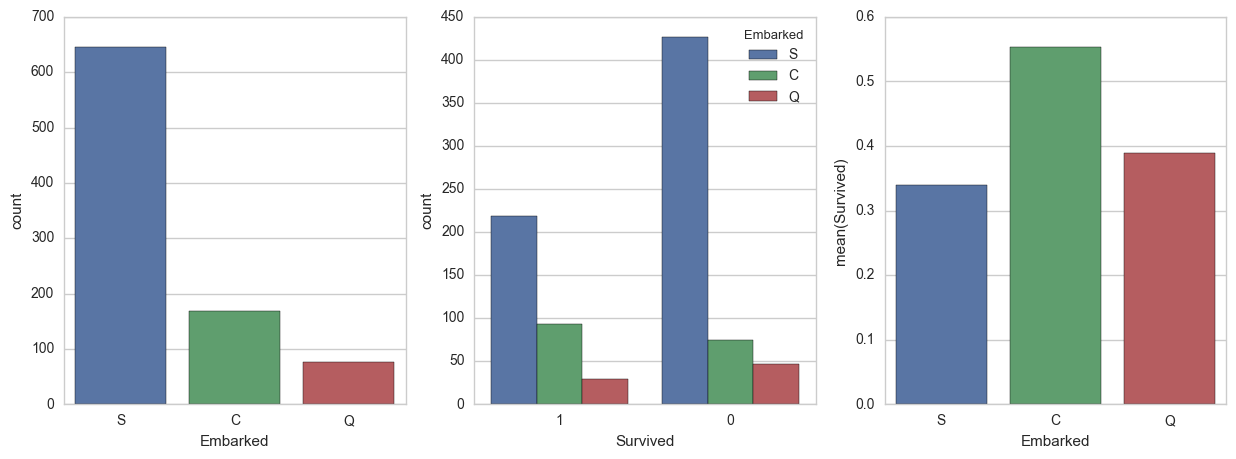

In [9]:
# Embarked
# 关于Embarked 只有两个缺失值，填充，使用众数填充
train_df['Embarked'] = train_df['Embarked'].fillna('S')

# 传入DataFrame变量参数，第一维x轴，第二维y轴（所有值的均值）,size控制高度，size*aspect控制宽度，hue参数表示在同一个图中作比较，
# row/col表示在水平或者垂直方向作比较，kind可以设置图表类型
sns.factorplot('Embarked','Survived',data = train_df, size = 4, aspect=3)

# 创建多个画布
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# 在指定画布上绘制直方图
sns.countplot(x='Embarked', data=train_df, ax = axis1)
sns.countplot(x='Survived',hue='Embarked', data=train_df,order=[1,0], ax=axis2)
sns.barplot(x='Embarked',y='Survived',ci=None,data=train_df,ax=axis3)

In [10]:
# 从理论上来说，为了方便，我们可以直接删除Embarked这一列
# 这个方案说，由于Embarked S的存活率太低，所以删除，我觉得有问题，因为这样才能体现区分度，适合模型训练

# pd.get_dummies方法 根据属性值的类别，生成新的特征，特征值为0或1
embark_dummies_titanic = pd.get_dummies(train_df['Embarked'])
embark_dummies_titanic.drop(['S'],axis=1, inplace=True)

embark_dummies_test = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

# 合并特征
train_df = train_df.join(embark_dummies_titanic)
test_df = test_df.join(embark_dummies_test)

In [11]:
# Embarked 已经由 其值 C Q代替，故删除Embarked这列
train_df.drop(['Embarked'], axis=1, inplace=True)
test_df.drop(['Embarked'],axis=1, inplace=True)

In [12]:
 # 只对test作该处理，因为测试集中存在缺省值，这里用中位数填充，考虑到数据的倾斜性
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

# convert from float to int
train_df['Fare'] = train_df['Fare'].astype(int)
test_df['Fare'] = test_df['Fare'].astype(int)

fare_not_survived = train_df['Fare'][train_df['Survived'] == 0]
fare_survived = train_df['Fare'][train_df['Survived'] == 1]
 

In [13]:
# get average and std for fare of survived/ not survived passengers
average_fare = pd.DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = pd.DataFrame([fare_not_survived.std(), fare_survived.std()])

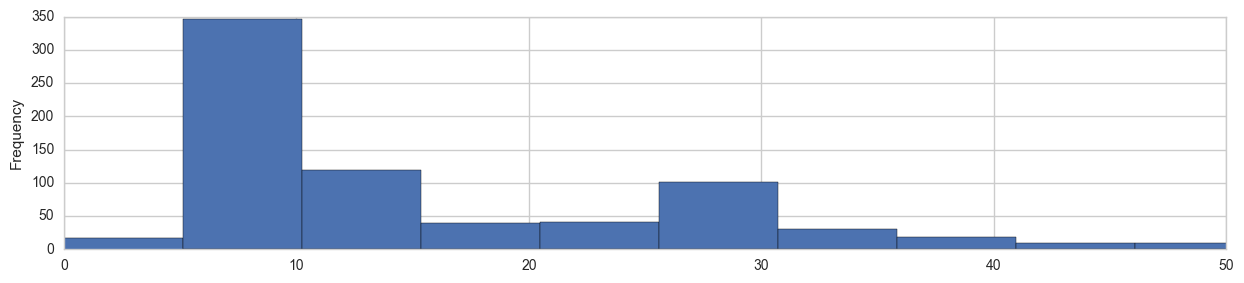

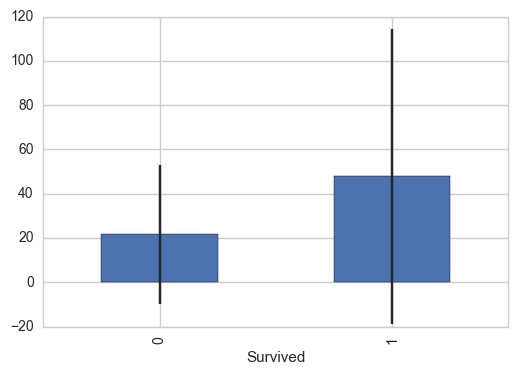

In [14]:
# plot
# 注意直方图（hist）和条形图（bar）的区别，直方图中各矩形是连续的，高度表示各小组个数，条形图则是分开的，高度有具体意义
# xlim表示只在这个范围内作图，整个值域除以bins 等于间隔多少有一个条；也就是说，bins控制总共的条个数
train_df['Fare'].plot(kind='hist', figsize=(15,3), bins=100,xlim=(0,50))

# 添加label
average_fare.index.names = std_fare.index.names = ['Survived']

# 显示均值
average_fare.plot(yerr=std_fare,kind='bar',legend=False)


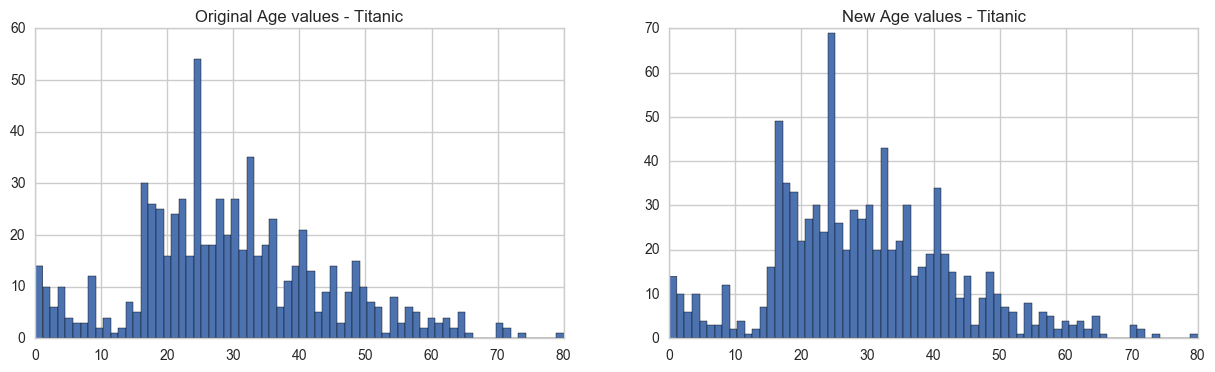

In [15]:
# age
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# get average,std, and numbers of NaN values in train_df
average_age_trian = train_df['Age'].mean()
std_age_trian = train_df['Age'].std()
count_nan_trian = train_df['Age'].isnull().sum()
# get average,std, and numbers of NaN values in test_df
average_age_test = test_df['Age'].mean()
std_age_test = test_df['Age'].std()
count_nan_test = test_df['Age'].isnull().sum()

# plot original Age values
train_df['Age'].dropna().astype(int).hist(bins=70,ax=axis1)

## 使用随机值填充NaN值
# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_trian-std_age_trian, average_age_trian+std_age_trian, size=count_nan_trian)
rand_2 = np.random.randint(average_age_test-std_age_test, average_age_test+std_age_test, size=count_nan_test)

train_df.loc[train_df['Age'].isnull(), 'Age'] = rand_1
test_df.loc[test_df['Age'].isnull(),'Age'] = rand_2

# convert from float to int
train_df['Age'] = train_df['Age'].astype(int)
test_df['Age'] = test_df['Age'].astype(int)

# plot new Age values
train_df['Age'].hist(bins=70, ax=axis2)

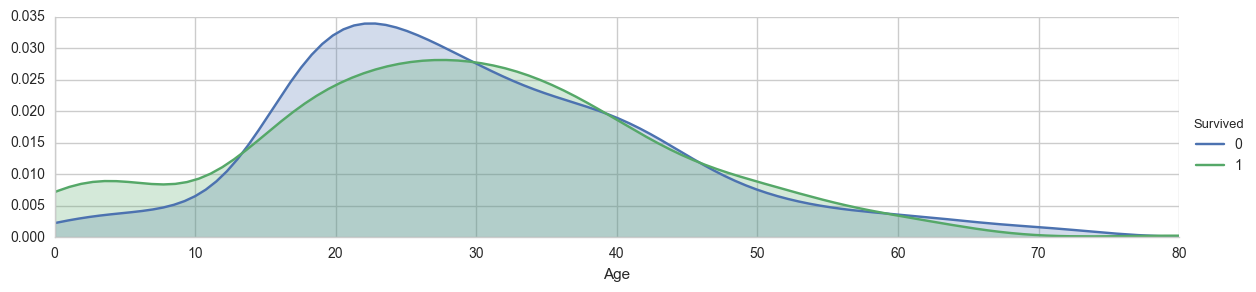

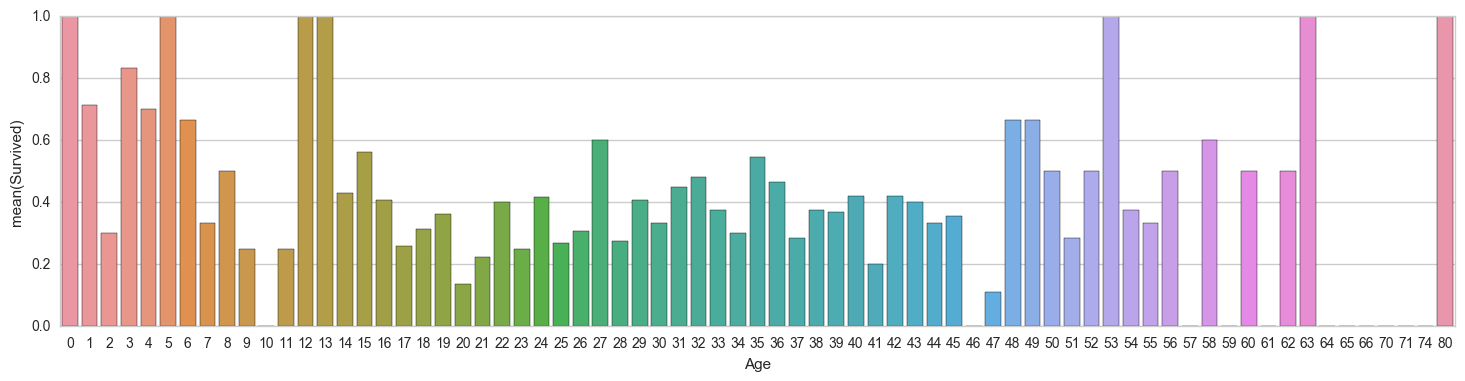

In [16]:
# 密度图
facet = sns.FacetGrid(train_df, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train_df['Age'].max()))
facet.add_legend()

fig, axis1 = plt.subplots(1,1,figsize=(18,4)) # 这一行必须要有，否则下面图会覆盖上面的，表明需要在新的画布上进行绘图
# as_index 表示是否将聚合的值 作为index，
#average_age = train_df[['Age','Survived']].groupby(['Age'], as_index=False).mean()
sns.barplot(x='Age',y='Survived', data=train_df, ci=None)

In [17]:
# Cabin 缺失值太多，应该不会对最终结果产生太多影响，故删除
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

In [18]:
# family 合并Sib Sp and Parch as family member
train_df['Family'] = train_df['Parch'] + train_df['SibSp']
train_df['Family'].loc[train_df['Family']>0] = 1
train_df['Family'].loc[train_df['Family'] == 0] = 0

test_df['Family'] = test_df['Parch'] + test_df['SibSp']
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0

# drop
train_df.drop(['SibSp','Parch'], axis=1, inplace=True)
test_df.drop(['SibSp','Parch'], axis=1, inplace=True)

D:\Python\Anaconda\Anaconda2.7\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


[<matplotlib.text.Text at 0xe49d630>, <matplotlib.text.Text at 0xe059be0>]

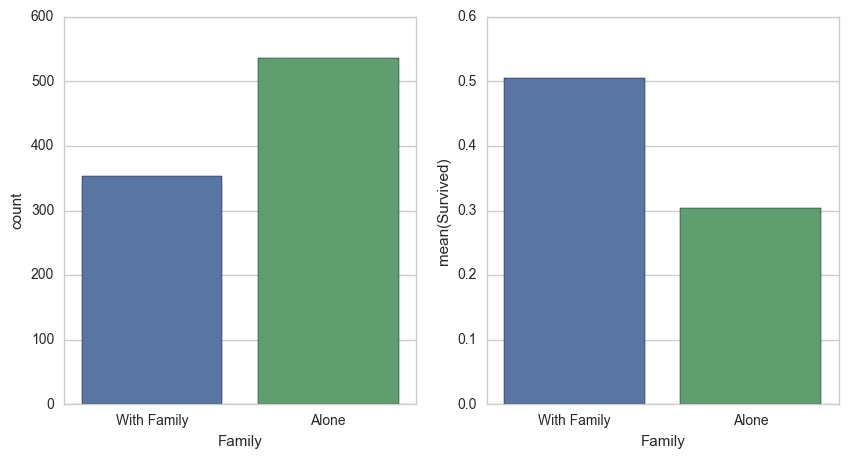

In [19]:
# plot sharex 作用使得此画布中的所有子画布公用一个
fig, (axis1,axis2) = plt.subplots(1,2, sharex=True, figsize=(10,5))

sns.countplot(x='Family', data=train_df, order=[1,0], ax=axis1)

#family_prec = train_df[['Family','Survived']].groupby(['Family'], as_index=False).mean()
sns.barplot(x='Family',y='Survived', data = train_df, order=[1,0], ci=None,ax=axis2)

axis1.set_xticklabels(['With Family','Alone'], rotation=0)

In [20]:
# Sex 
# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex

train_df['Person'] = train_df[['Age','Sex']].apply(get_person, axis=1)
test_df['Person'] = test_df[['Age','Sex']].apply(get_person, axis=1)

train_df.drop(['Sex'], axis=1, inplace=True)
test_df.drop(['Sex'], axis=1, inplace=True)


In [24]:
person_dummies_train = pd.get_dummies(train_df['Person'])
# 换名称，默认都是根据值的字典顺序排列的
person_dummies_train.columns = ['Child','Female','Male']
person_dummies_train.drop(['Male'],axis=1,inplace=True)

person_dummies_test = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'],axis=1, inplace=True)

train_df = train_df.join(person_dummies_train)
test_df = test_df.join(person_dummies_test)

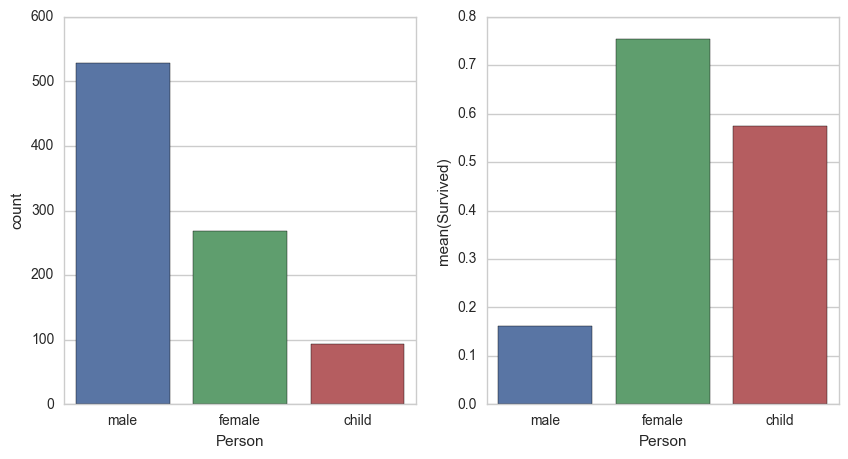

In [27]:
fig, (axis1,axis2) = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x='Person', data=train_df, ax= axis1)
sns.barplot(x='Person',y='Survived', data= train_df, ax=axis2, ci=None)

In [30]:
train_df.drop(['Person'], axis=1, inplace=True)
test_df.drop(['Person'], axis=1, inplace=True)

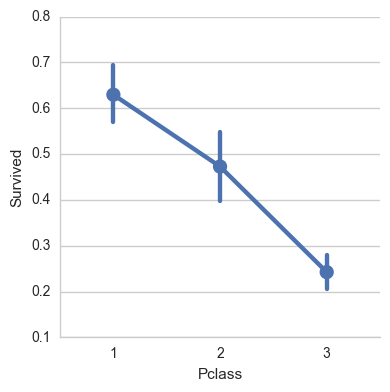

In [33]:
# Pclass
sns.factorplot('Pclass','Survived', data=train_df)

In [34]:
pclass_dummies_train = pd.get_dummies(train_df['Pclass'])
pclass_dummies_train.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_train.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

In [35]:
train_df.drop(['Pclass'], axis=1, inplace=True)
test_df.drop(['Pclass'], axis=1, inplace=True)

train_df = train_df.join(pclass_dummies_train)
test_df = test_df.join(pclass_dummies_test)

In [39]:
# define training and testing sets

X_train = train_df.drop('Survived', axis=1)
Y_train = train_df['Survived']
X_test = test_df.drop(['PassengerId'], axis=1).copy()

In [44]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
logreg.score(X_train, Y_train)

0.80695847362514028

In [45]:
# SVM
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
svc.score(X_train, Y_train)

0.84287317620650959

In [46]:
# random forests
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)

0.96520763187429859

In [47]:
# knn
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
knn.score(X_train, Y_train)

0.82940516273849607

In [48]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
gaussian.score(X_train, Y_train)

0.75757575757575757

In [49]:
submission = pd.DataFrame({
        "PassengerId": test_df['PassengerId'],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)